In [1]:
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import math
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
import time
import warnings
warnings.filterwarnings("ignore")



# Xử lý bộ Crafield

In [2]:
#đọc query
query_full = []
with open("query.txt") as f:
    lines = f.readlines()
    query_full = []
    for i in lines:
        query_full.append('' .join((z for z in i if not z.isdigit())).lower())

In [3]:
def numericalSort(value):
    '''
    đọc theo số thứ tự file txt
    '''
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
#đọc query trong tập Cranfield
result_cra = []
for i in sorted(glob.glob('./RES/*'),key=numericalSort):  #lọc chữ số
    temp = []
    with open(i) as f:
        lines = []
        read = f.readlines()
        for i in read:
            lines.append(i.split(" ")[-1].split("\t")[0])
        temp.extend(lines)
    result_cra.append(temp)

In [5]:
def loc_chu_so(url):
    '''
    xóa các số trong văn bản
    '''
    txt = []
    for i in sorted(glob.glob(url),key=numericalSort):  #lọc chữ số
        with open(i) as f:
            lines = f.readlines()
            if len(lines) == 0: lines = " "
            char_str = ['' .join((z for z in lines[0] if not z.isdigit()))]
            txt.extend(char_str)
    return txt

# Xử lý bộ Corpus

In [213]:
def loc_chu_so_corpus(txt):
    for i in txt.keys():
        
        char_str = ['' .join((z for z in txt[i] if not z.isdigit()))]
        txt[i] = char_str
    return txt

# Chung

In [6]:
def pos(word):
    ps = PorterStemmer()
    if word == ps.stem(word): return word
    return pos(ps.stem(word))

In [7]:
def le(word):
    lemmatizer = WordNetLemmatizer()
    if word == lemmatizer.lemmatize(word): return word
    return le(lemmatizer.lemmatize(word))

In [8]:
def data_pretreated_lemma(i):
    '''
    Xử lý dữ liệu theo lemma
    '''
    tokenizer = RegexpTokenizer(r'\w+')

    stop = set(stopwords.words("english"))
    
    temp = tokenizer.tokenize(i)
    output = [w for w in temp if not w in stop]
    temp_le=[le(word) for word in output]
    #final = [word for word in temp_stem if wordnet.synsets(word)]
  
    final_final = [word for word in temp_le if not len(word)<3]
    return final_final

In [9]:
def data_pretreated_stem(i):
    '''
    Xử lý dữ liệu theo stem
    '''
    tokenizer = RegexpTokenizer(r'\w+')
 
    stop = set(stopwords.words("english"))
    
    temp = tokenizer.tokenize(i)
    output = [w for w in temp if not w in stop]
    temp_stem=[pos(word) for word in output]
    #final = [word for word in temp_stem if wordnet.synsets(word)]
  
    final_final = [word for word in temp_stem if not len(word)<3]
    return final_final

In [54]:
def make_txt(txt):
    s = ""
    for i in txt:
       s += " " + i
    return s


In [11]:
def make_docs(txt):
    docs = []
    for i in txt:
        docs.append(data_pretreated_stem(i))
    return docs


In [12]:
def cal_precision(y_pred,y_true):
    '''
    hàm tính precision không nội suy
    sử dụng phương pháp cắt n=10
    
    '''
    pre = []
    count = 0
    for i in y_pred[0:10]:
        #print(i)
        if str(i[0]) in y_true:
            count+=1
            
    
    pre.append(count/10)
    return pre

In [13]:
def cal_recall(y_pred,y_true):
    '''
    hàm tính recall trong 10 bộ dữ liệu trả về
    
    '''
    pre = []
    count = 0
    for i in y_pred[0:10]:
        #print(i)
        if str(i[0]) in y_true:
            count+=1
            
    
    pre.append(count/len(y_true))
    return pre

In [14]:
def interpolation(y_pred,y_true):
    total = len(y_true)

    recall = [0.0]
    precision = [1.0]
    count = 0 

    for i in range (0,len(y_pred)):
     
        if str(y_pred[i].astype(int)) in y_true: 
            count +=1
            precision.append(count/(i+1))
            recall.append(count/total)

    mark = 0
    inter = []

    i = 0
    while(mark<1):
 
        if(i>= len(recall)): 
            inter.append(inter[-1])
            mark+=0.1
            continue
        if(mark<=recall[i]):
            inter.append(precision[i])
            mark+=0.1
         
        else:
            i+=1

    return inter
    

In [15]:
txt = loc_chu_so('./Cranfield/*')
#docs = make_docs(txt)

# Phân tích dữ liệu

## Bộ dữ liệu Cranfield

In [2]:
url_cra = './Cranfield/*'
stop = set(stopwords.words("english"))

In [5]:

upper = []
digit = []
pattern = re.compile(r'\w+')
reg = []
no =[]
stop_w = {word:0 for word in stopwords.words("english")}
st = []


for i in sorted(glob.glob(url_cra),key=numericalSort):  
    with open(i) as f:
        lines = f.readlines()
        if len(lines) == 0: lines = " "
        index = -1
        index_digit = -1
        index_re = -1
        index_st = -1
        for word in lines[0].split(" "):
            if(len(word)==0): continue
            if word[0].isupper() == True: index = i
            if word[0].isdigit() == True: index_digit = i
            if re.fullmatch(pattern, word[0]) != True: index_re = i
            if word in stop:
                stop_w[word] += 1
                index_st = i

       
        if (index != -1): upper.append(index)
        if (index_digit != -1 ):  digit.append(index_digit)
        if (index_re!=-1): reg.append(index_re)
        else: no.append(i)
        if index_st != -1: st.append(i)


        
          
        
print("Số lượng các text chứa từ viết hoa là: ", len(upper))
print("Số lượng các từ là số trong bộ dữ liệu: ", len(digit))
print("Số lượng các text chứa kí hiệu trong bộ dữ liệu: ", len(reg))
print("Số lượng các text chứa stop words bộ dữ liệu: ", len(st))




Số lượng các text chứa từ viết hoa là:  0
Số lượng các từ là số trong bộ dữ liệu:  607
Số lượng các text chứa kí hiệu trong bộ dữ liệu:  1398
Số lượng các text chứa stop words bộ dữ liệu:  1398


Bộ dữ liệu Cranfield không có từ viết hoa, do đó ta không cần phải sử dụng kĩ thuật lower các từ.

Có 607 kí tự là số, ta sẽ loại bỏ các kí tự này vì nó không mang ý nghĩa.

Hầu như toàn bộ các text đều chứa kí hiệu (phẩy, chấm,...). Ta cũng sẽ loại bỏ các kí hiệu này

In [6]:
no

['./Cranfield\\471.txt', './Cranfield\\995.txt']

In [135]:
inverse = [(value, key) for key, value in stop_w.items() if value>0]
inverse = sorted(inverse,reverse=True)

In [137]:
inverse[0:5]

[(19426, 'the'), (12656, 'of'), (6100, 'and'), (5828, 'a'), (4590, 'in')]

In [139]:
len(stop_w) - len(inverse)

60

Có 60 từ stop words trong bộ từ điển không nằm trong bộ dữ liệu.

In [51]:
txt_cra = loc_chu_so('./Cranfield/*')

In [52]:
dict_stem = {}
for i in txt_cra:
    for word in data_pretreated_stem(i):
        dict_stem[word] = 0

In [53]:
len(dict_stem)

4169

In [47]:
dict_lemma = {}
for i in txt_cra:
    for word in data_pretreated_lemma(i):
        dict_lemma[word] = 0

In [48]:
len(dict_lemma)

6022

## Bộ dữ liệu Nfcorpus

In [181]:
url_nf = './nfcorpus/train.docs'

In [187]:
with open(url_nf) as f:
    raw = f.readlines()


In [215]:
txt = {}
for i in raw:
    id, content = i.split("\t")
    txt[id] = content
len(txt)

3612

In [219]:
stop = set(stopwords.words("english"))

In [227]:
upper = []
digit = []
pattern = re.compile(r'\w+')
reg = []
no =[]
stop_w = {word:0 for word in stopwords.words("english")}
st = []

for i in txt.keys():
        lines = txt[i]
        index = -1
        index_digit = -1
        index_re = -1
        index_st = -1
        for word in lines.split(" "):
            if(len(word)==0): continue
            if word[0].isupper() == True: index = i
            if word[0].isdigit() == True: index_digit = i
            if re.fullmatch(pattern, word[0]) != True: index_re = i
            if word in stop:
                stop_w[word] += 1
                index_st = i

       
        if (index != -1): upper.append(index)
        if (index_digit != -1 ):  digit.append(index_digit)
        if (index_re!=-1): reg.append(index_re)
        if index_st != -1: st.append(i)
        else: no.append(i)


        
          
        
print("Số lượng các text chứa từ viết hoa là: ", len(upper))
print("Số lượng các từ là số trong bộ dữ liệu: ", len(digit))
print("Số lượng các text chứa kí hiệu trong bộ dữ liệu: ", len(reg))
print("Số lượng các text chứa stop words bộ dữ liệu: ", len(st))


Số lượng các text chứa từ viết hoa là:  0
Số lượng các từ là số trong bộ dữ liệu:  0
Số lượng các text chứa kí hiệu trong bộ dữ liệu:  3612
Số lượng các text chứa stop words bộ dữ liệu:  321


In [228]:
no

['MED-10',
 'MED-14',
 'MED-118',
 'MED-301',
 'MED-329',
 'MED-330',
 'MED-332',
 'MED-334',
 'MED-335',
 'MED-398',
 'MED-557',
 'MED-666',
 'MED-691',
 'MED-692',
 'MED-702',
 'MED-706',
 'MED-708',
 'MED-709',
 'MED-711',
 'MED-712',
 'MED-713',
 'MED-714',
 'MED-716',
 'MED-717',
 'MED-718',
 'MED-719',
 'MED-720',
 'MED-721',
 'MED-722',
 'MED-723',
 'MED-724',
 'MED-726',
 'MED-727',
 'MED-729',
 'MED-730',
 'MED-731',
 'MED-732',
 'MED-733',
 'MED-735',
 'MED-736',
 'MED-743',
 'MED-744',
 'MED-745',
 'MED-746',
 'MED-748',
 'MED-752',
 'MED-753',
 'MED-754',
 'MED-756',
 'MED-757',
 'MED-758',
 'MED-759',
 'MED-760',
 'MED-761',
 'MED-762',
 'MED-816',
 'MED-818',
 'MED-819',
 'MED-820',
 'MED-821',
 'MED-822',
 'MED-823',
 'MED-824',
 'MED-825',
 'MED-826',
 'MED-827',
 'MED-828',
 'MED-829',
 'MED-830',
 'MED-831',
 'MED-832',
 'MED-833',
 'MED-834',
 'MED-835',
 'MED-836',
 'MED-838',
 'MED-839',
 'MED-840',
 'MED-841',
 'MED-842',
 'MED-843',
 'MED-844',
 'MED-845',
 'MED-

# Xử lý data

In [100]:
txt_cra = loc_chu_so('./Cranfield/*')

In [151]:
stem_cra = []
lem_cra = []
stem_query = []
lem_query = []
for i in txt_cra:
    stem_cra.append(data_pretreated_stem(i))
    lem_cra.append(data_pretreated_lemma(i))
for i in query_full:
    stem_query.append(data_pretreated_stem(i))
    lem_query.append(data_pretreated_lemma(i))

# Vector Space

## Hàm

In [125]:
def make_inverted(txt_term):

    '''
    tạo thành các term có dạng là một dict, từ -> số lượng tài liệu chứa nó, tần số lặp từ đó trong tất cả tài liệu. Vd:
    'deepest' : {So_luong_tai_lieu: 1,
                 Tan_so: 2
                }
    '''
    tm = 0
    start = time.time()
    words = {}
    normal = np.zeros(1400)
    for i in txt_term:
        
  
        start= time.time()
        current_index = txt_term.index(i)+1
       
        for word in i:
            
            if word not in words: 
                words[word] = {
                "So_luong_tai_lieu" : [current_index], 
                "Tan_so" : 1,
                "Posting": None
                }
                words[word]["Posting"] = [[current_index,1,0]]
                
            else:
                words[word]["Tan_so"]+=1
                if current_index not in words[word]["So_luong_tai_lieu"]: 
                    words[word]["So_luong_tai_lieu"].append(current_index)
                if words[word]["Posting"][-1][0] == current_index: words[word]["Posting"][-1][1] +=1 
                else: words[word]["Posting"].append([current_index,1,0])
     
    for i in words:
        words[i]["So_luong_tai_lieu"] = len(words[i]["So_luong_tai_lieu"])
        for pos in words[i]["Posting"]:
            docid = pos[0]
            tf = pos[1]
            idf = np.log10((1400+1)/words[i]["Tan_so"])
            pos[2] = tf * idf
            normal[docid-1] += pow(tf * idf,2)
 
    for word in words:
        for i in words[word]["Posting"]:
            i[2] /= math.sqrt(normal[i[0]-1])
 
    end = time.time()
    tm = end - start    

    return words, tm



In [167]:
def vector_qr(query):
    word = {}
    for i in query:
        if i not in word:
            word[i] = 1
        else: word[i] +=1
    return word

In [160]:
def vector_space(query1,txt,term):
    query = vector_qr(query1)
    relevance_scores = {}
    vector_query = []
    for word in query.copy():
        
        if word not in term: 
            query.pop(word)
            continue
        count = query[word]
        vector_query = count * np.log10((len(txt)+1)/term[word]["Tan_so"])

        for doc in term[word]["Posting"]:
            score = vector_query * doc[2]
            if doc[0] not in relevance_scores:
                relevance_scores[doc[0]] = score
            else: relevance_scores[doc[0]] += score
     
    sorted_value = sorted(relevance_scores.items(), key=lambda x: x[1], reverse = True)
    return sorted_value


## Main

In [126]:
inverted_stem, time_stem = make_inverted(stem_cra)
inverted_lem, time_lem = make_inverted(lem_cra)

In [127]:
print("Thời gian lập chỉ mục với stem là: ", time_stem)
print("Thời gian lập chỉ mục với lem là: ", time_lem)

Thời gian lập chỉ mục với stem là:  0.23254776000976562
Thời gian lập chỉ mục với lem là:  0.24115657806396484


In [162]:
stem_query[0]

['similar',
 'law',
 'must',
 'obey',
 'construct',
 'aeroelast',
 'model',
 'heat',
 'high',
 'speed',
 'aircraft']

## Đánh giá

### Cranfield

#### Stem

In [170]:
start = time.time()
score_vp_recall = []
score_vp_pre = []
score_inter = []
for i in range (0,len(stem_query)):
    y_sp = vector_space(stem_query[i],txt,inverted_stem)
    score_vp_pre.append(cal_precision(y_sp,result_cra[i]))
    score_vp_recall.append(cal_recall(y_sp,result_cra[i]))
    score_inter.append(interpolation(np.array(y_sp)[:,0],result_cra[i]))
end = time.time()
print("Thời gian truy xuất với stem là:", end - start)

Thời gian truy xuất với stem là: 0.6720759868621826


In [171]:
np.mean(score_vp_pre)

0.26711111111111113

In [132]:
np.mean(score_vp_recall)

0.3909883923834424

In [133]:
map = []
for i in range(0,11):
    map.append(np.mean(np.array(score_inter)[:,i]))

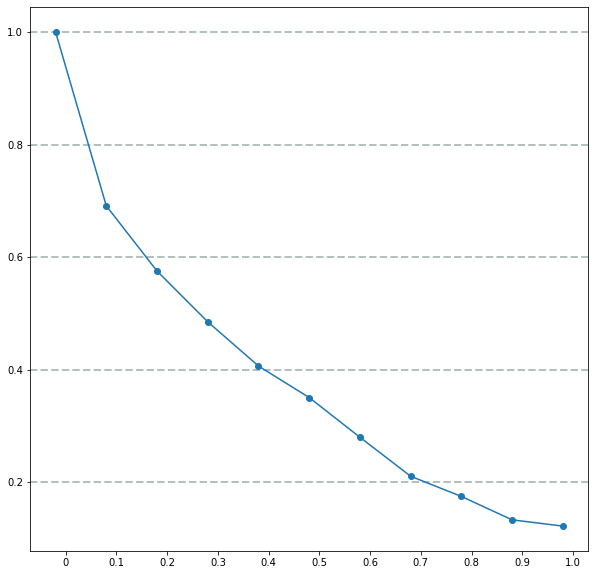

In [142]:
width = 0.2
fig = plt.figure(figsize = (10, 10))

plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.plot(np.arange(len(map)),map,marker = 'o')


plt.xticks([r + width for r in range(len(map))],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

#### Lem

In [179]:
start = time.time()
score_vp_recall = []
score_vp_pre = []
score_inter = []
for i in range (0,len(lem_query)):
    y_sp = vector_space(lem_query[i],txt,inverted_lem)
    score_vp_pre.append(cal_precision(y_sp,result_cra[i]))
    score_vp_recall.append(cal_recall(y_sp,result_cra[i]))

    score_inter.append(interpolation(np.array(y_sp)[:,0],result_cra[i]))
end = time.time()
print("Thời gian truy xuất với lem là:", end - start)

Thời gian truy xuất với lem là: 0.6003153324127197


In [175]:
np.mean(score_vp_pre)

0.26488888888888884

In [176]:
np.mean(score_vp_recall)

0.3892154911008617

In [177]:
map = []
for i in range(0,11):
    map.append(np.mean(np.array(score_inter)[:,i]))

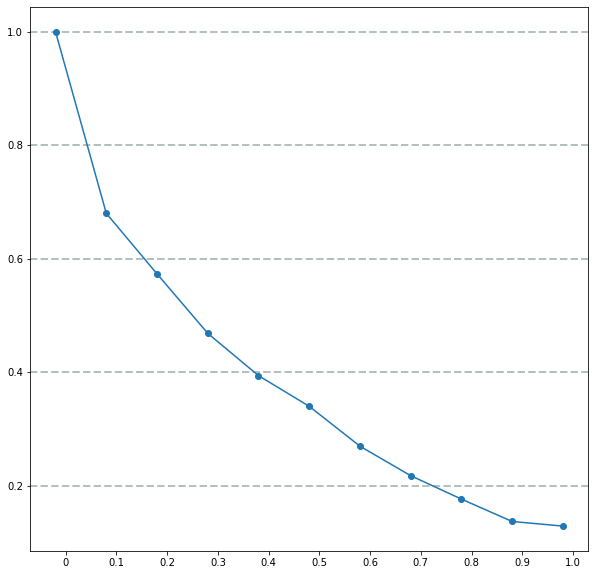

In [178]:
width = 0.2
fig = plt.figure(figsize = (10, 10))

plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.plot(np.arange(len(map)),map,marker = 'o')


plt.xticks([r + width for r in range(len(map))],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

# BIM

## Hàm

In [ ]:
def make_term_bim(txt_term):

    '''
    tạo thành các term có dạng là một dict, từ -> số lượng tài liệu chứa nó, tần số lặp từ đó trong tất cả tài liệu. Vd:
    'deepest' : {So_luong_tai_lieu: 1,
                 Tan_so: 2
                }
    '''
    words = {}
    for i in txt_term:
      
        final_final=tien_xu_ly(i)
        
        for word in final_final:
            
            if word not in words: 
                words[word] = {
                "So_luong_tai_lieu" : [txt_term.index(i)+1], 
                "Tan_so" : 1,
                "Posting": None,
                "Weight" : None
                }

            else:
                words[word]["Tan_so"]+=1
                current_index = txt_term.index(i)+1
                if current_index not in words[word]["So_luong_tai_lieu"]: 
                    words[word]["So_luong_tai_lieu"].append(current_index)
    for i in words:
        words[i]["So_luong_tai_lieu"] = len(words[i]["So_luong_tai_lieu"])
    return words

In [ ]:
def make_detail_term(txt_term):
    '''
    Chi tiết về term đó, từ -> số Id docs: số lần lặp trong doc đó. Vd
    conceived: {
                [1016, 1]
                [1268, 1]
    }
    
    '''
    words = {}
    for i in txt_term:
        final_final=tien_xu_ly(i)
        current_index = txt_term.index(i)+1
        for word in final_final:
            if (word not in words):
                words[word] = [[current_index,1,0]]
             
            else:  
                if words[word][-1][0] == current_index: words[word][-1][1] +=1 
                else: words[word].append([current_index,1,0])
            
            #print(list(words[word][0,:]))
       

    return words    

In [ ]:
def bim1(term,txt):
    '''
    trường hợp 1 chưa có thông tin
    '''
    weights = {}

    for word in term:
        p = 0.5
        p_= term[word]['So_luong_tai_lieu']/(len(txt))
        #w = np.log2(p/p_)
        w = p/p_
        weights[word] = w


    return weights

In [ ]:
def make_index(term1, detail_term1,weight):
    for word in term1:
        term1[word]["Posting"] = detail_term1[word]
        term1[word]["Weight"] = weight[word]
    return term1 

In [ ]:
def update(term,query,docs_relevant,txt):
    '''
    docs_relevant: tập các văn bản liên quan 
    Rt: số tài liệu liên quan đến term
    Nr: số tài liệu liên quan
    p = (Rt+0.5) / (Nr+1)
    p- = (Nt-Rt + 0.5)/(N-Nr + 1)
    '''
    query = make_term_bim(tien_xu_ly(query))
    Nr = len(docs_relevant)
    for word in query:
        id = []
        id.append(count for count in docs_relevant if count in np.array(term[word]["Posting"])[:,0])
        Rt = len(id)
        p = (Rt+0.5) / (Nr+1)
        p_ = (term[word]["So_luong_tai_lieu"]-Rt + 0.5)/(len(txt)-Nr + 1)
        term[word]["Weight"] = p / p_

In [ ]:
def relevant_bim(term,query,txt):
    relevance_scores = {}
    doc_id = 0
    query = make_term_bim(tien_xu_ly(query))
    for i in range (0,len(txt)):
        doc_id = i+1
        score = -1
        for word in query:
            if word in txt[i]:
                if score == -1: score = 1
           
                score *= term[word]["Weight"]
                
        if(score==-1): continue
        relevance_scores[doc_id] = score
    sorted_value = sorted(relevance_scores.items(), key=lambda x: x[1], reverse = True)
    return sorted_value

## Main

In [ ]:
term = make_term_bim(txt)
detail_term = make_detail_term(txt)
weight = bim1(term,txt)
index= make_index(term,detail_term,weight)

## Đánh giá

In [ ]:
score_bim_pre = []
score_bim_recall = []
score_bim_inter = []
for i in range (0,len(query_full)):
    y_bim = relevant_bim(term,query_full[i],docs)
    score_bim_pre.append(cal_precision(y_bim,result[i]))
    score_bim_recall.append(cal_recall(y_bim,result[i]))
    score_bim_inter.append(interpolation(np.array(y_bim)[:,0],result[i]))



### Precision

In [ ]:
np.mean(score_bim_pre)

0.2497777777777778

### Recall

In [ ]:
np.mean(score_bim_recall)

0.37159532548779545

### MAP

In [ ]:
map = []
for i in range(0,11):
    map.append(np.mean(np.array(score_bim_inter)[:,i]))

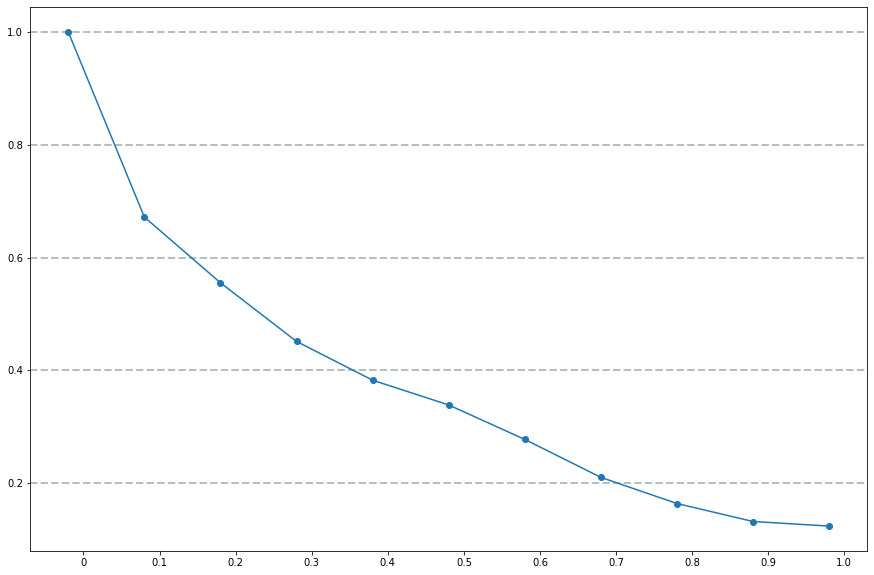

In [ ]:
width = 0.2
fig = plt.figure(figsize = (15, 10))
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.plot(np.arange(len(map)),map,marker = 'o')

plt.xticks([r + width for r in range(len(map))],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

# Test với thư viện

In [ ]:
D = txt

In [ ]:
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.analysis import StandardAnalyzer

schema = Schema(docid=STORED(), content=TEXT(stored=True, analyzer=StandardAnalyzer()))
ix = create_in("ind", schema)
writer = ix.writer()
for i in range(len(D)):
  writer.add_document(docid="{}".format(i+1), content=D[i])
writer.commit()


In [ ]:
from whoosh import qparser
from whoosh import scoring
import whoosh.index as index

ind = index.open_dir("ind")
searcher = ind.searcher(weighting=scoring.TF_IDF())

parser = qparser.QueryParser("content", ind.schema, group=qparser.OrGroup)
score_wh_pre = []
score_wh_recall = []
score_wh_inter = []
for q in range (0,len(query_full)):
  query = parser.parse(query_full[q])
  results = searcher.search(query, limit=None)
  y_wh = []
  for i in range(len(results)):
    y_wh.append([results[i]['docid']])



  score_wh_pre.append(cal_precision(y_wh,result[q]))
  score_wh_recall.append(cal_recall(y_wh,result[q]))

  score_wh_inter.append(interpolation(np.array(y_wh)[:,0],result[q]))

 

In [ ]:
np.mean(score_wh_pre)

0.20622222222222225

In [ ]:
np.mean(score_wh_recall)

0.2955906669884002

In [ ]:
map = []
for i in range(0,11):
    map.append(np.mean(np.array(score_wh_inter)[:,i]))

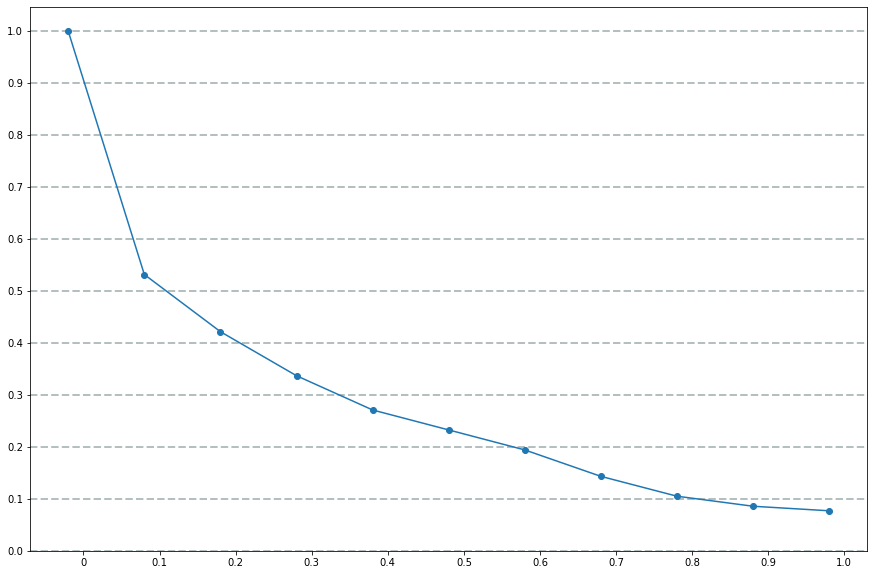

In [ ]:
width = 0.2
fig = plt.figure(figsize = (15, 10))
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.plot(np.arange(len(map)),map,marker = 'o')
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([r + width for r in range(len(map))],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

In [306]:
def make_term(txt_term):

    '''
    tạo thành các term có dạng là một dict, từ -> số lượng tài liệu chứa nó, tần số lặp từ đó trong tất cả tài liệu. Vd:
    'deepest' : {So_luong_tai_lieu: 1,
                 Tan_so: 2
                }
    '''
    words = {}
    for i in txt_term:
      
        final_final=data_pretreated_stem(i)
        
        for word in final_final:
            
            if word not in words: 
                words[word] = {
                "So_luong_tai_lieu" : [txt_term.index(i)+1], 
                "Tan_so" : 1,
                "Posting": None
                }

            else:
                words[word]["Tan_so"]+=1
                current_index = txt_term.index(i)+1
                if current_index not in words[word]["So_luong_tai_lieu"]: 
                    words[word]["So_luong_tai_lieu"].append(current_index)
    for i in words:
        words[i]["So_luong_tai_lieu"] = len(words[i]["So_luong_tai_lieu"])
    return words

In [307]:
def make_detail_term(txt_term):
    '''
 
    
    '''
    words = {}
    for i in txt_term:
        final_final=data_pretreated_stem(i)
        current_index = txt_term.index(i)+1
        for word in final_final:
            if (word not in words):
                words[word] = [[current_index,1,0]]
             
            else:  
                if words[word][-1][0] == current_index: words[word][-1][1] +=1 
                else: words[word].append([current_index,1,0])
            
            #print(list(words[word][0,:]))
       

    return words         

In [308]:
def make_index(term1, detail_term1):
    for word in term1:
        term1[word]["Posting"] = detail_term1[word]
    return term1 

In [309]:
def make_weight_for_vector(index,number):
    normal = np.zeros(number)
    for word in index:
        for i in index[word]["Posting"]:
            tf = i[1]
            idf = np.log10((number+1)/index[word]["Tan_so"])
            i[2] = tf*idf
            normal[i[0]-1] += pow((tf*idf),2)

    return index, np.sqrt(normal)

In [310]:
def normal_weight_vector(index,normal):
    for word in index:
        for i in index[word]["Posting"]:
            i[2] /= normal[i[0]-1]
    return index

In [311]:
def vector_docs(normal_weight,txt,term):
    vector_doc = []
    for i in range (0,len(txt)):
        doc_id = i+1
        vector = []
        for word in term:
            
    
            if word not in txt[i]:
                term_doc = 0
            else: 
                index = list(np.array(normal_weight[word]["Posting"])[:,0]).index(doc_id)
                term_doc = normal_weight[word]['Posting'][index][2]
            vector.append(term_doc)

            ######

            
            

        vector_doc.append(vector)
    return vector_doc


In [316]:
def vector_space(query,normal_weight,txt,term,vector_doc):
    query = make_term(data_pretreated_stem(query))
    
    relevance_scores = {}
    for i in range (0,len(txt)):
        doc_id = i+1
        vector_query = np.zeros(len(term))
        
        for word in query:
            if word not in term: continue
            count = query[word]['Tan_so']
            index = list(term).index(word)
            vector_query[index] = count * np.log10((len(txt)+1)/term[word]["Tan_so"])

        score = cosine_similarity(np.array(vector_query).reshape(1,-1),np.array(vector_doc[i]).reshape(1,-1))
        if (score<=0): continue
        relevance_scores[doc_id] =score
    sorted_value = sorted(relevance_scores.items(), key=lambda x: x[1], reverse = True)
    return sorted_value

In [313]:
term = make_term(txt)
detail_term = make_detail_term(txt)

In [314]:
index = make_index(term,detail_term)

In [315]:
not_normal, normal = make_weight_for_vector(term,len(txt))
normal_weight = normal_weight_vector(not_normal,normal)

In [282]:
docs = make_docs(txt)

In [317]:
vector_doc = vector_docs(normal_weight,docs,term)

In [318]:
y_sp = vector_space(query_full[0],normal_weight,docs,term,vector_doc)
cal_precision(y_sp,result_cra[0])

[0.5]

In [320]:
cal_recall(y_sp,result_cra[0])

[0.1724137931034483]

In [319]:
y_sp

[(51, array([[0.22077745]])),
 (184, array([[0.21843362]])),
 (12, array([[0.18638673]])),
 (746, array([[0.18018252]])),
 (944, array([[0.17362113]])),
 (359, array([[0.17315305]])),
 (573, array([[0.16723623]])),
 (665, array([[0.15631957]])),
 (56, array([[0.15099249]])),
 (879, array([[0.14829282]])),
 (878, array([[0.14174238]])),
 (14, array([[0.12057273]])),
 (1186, array([[0.11934451]])),
 (486, array([[0.11889528]])),
 (1361, array([[0.11499969]])),
 (141, array([[0.1046722]])),
 (414, array([[0.10390226]])),
 (13, array([[0.1030033]])),
 (817, array([[0.10156745]])),
 (875, array([[0.10085828]])),
 (758, array([[0.09665793]])),
 (435, array([[0.09491432]])),
 (253, array([[0.09284161]])),
 (1194, array([[0.09079319]])),
 (172, array([[0.08957981]])),
 (818, array([[0.08932672]])),
 (1340, array([[0.08892334]])),
 (781, array([[0.08890525]])),
 (663, array([[0.08782797]])),
 (104, array([[0.08385492]])),
 (219, array([[0.08231241]])),
 (332, array([[0.08215066]])),
 (1048, arr

In [ ]:
score_vp_recall = []
score_vp_pre = []
score_inter = []
for i in range (0,len(query_full)):
    y_sp = vector_space(query_full[i],normal_weight,docs,term,vector_doc)
    score_vp_pre.append(cal_precision(y_sp,result[i]))
    score_vp_recall.append(cal_recall(y_sp,result[i]))
    score_inter.append(interpolation(np.array(y_sp)[:,0],result[i]))